# AI-Based Productivity Prediction for Garment Workers

**Course:** Predictive Analytics in Business  
**Objective:** To analyze garment worker productivity data and build a predictive model to estimate actual productivity.

This notebook follows a complete data analytics pipeline including data collection, exploratory data analysis, preprocessing, feature selection, model training, evaluation, and deployment.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")


In [8]:
df = pd.read_csv("garments_worker_productivity.csv")
df.head()


,date,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,01-01-2015,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,01-01-2015,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,01-01-2015,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,01-01-2015,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,01-01-2015,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


Initial Data Check

In [9]:
df.info()
df.isnull().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 131.1+ 

np.int64(0)

In [10]:
def data_quality_report(df):
    report = pd.DataFrame({
        "Missing %": df.isnull().mean() * 100,
        "Unique Values": df.nunique(),
        "Data Type": df.dtypes
    })
    return report.sort_values(by="Missing %", ascending=False)

data_quality_report(df)


,Missing %,Unique Values,Data Type
wip,42.272348,548,float64
date,0.000000,59,object
day,0.000000,6,object
team,0.000000,12,int64
targeted_productivity,0.000000,9,float64
department,0.000000,2,object
smv,0.000000,70,float64
over_time,0.000000,143,int64
incentive,0.000000,48,int64
idle_time,0.000000,12,float64


Basic Overview

## Descriptive Statistical Analysis

Descriptive statistics are used to summarize and understand the central tendency, dispersion, and distribution of the dataset. This includes measures such as mean, median, standard deviation, skewness, and kurtosis.


In [11]:
df.describe()


,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


Mean, Median, Mode

In [12]:
df.mean(numeric_only=True)
df.median(numeric_only=True)
df.mode().iloc[0]


,0
date,03-11-2015
department,sewing
day,Wednesday
team,2
targeted_productivity,0.8
smv,3.94
wip,1039.0
over_time,960.0
incentive,0.0
idle_time,0.0


Standard Deviation, Variance, Range

In [13]:
df.std(numeric_only=True)
df.var(numeric_only=True)

df.max(numeric_only=True) - df.min(numeric_only=True)


,0
team,11.000000
targeted_productivity,0.730000
smv,51.660000
wip,23115.000000
over_time,25920.000000
incentive,3600.000000
idle_time,300.000000
idle_men,45.000000
no_of_style_change,2.000000
no_of_workers,87.000000


Min, Max, Percentiles, Quartiles

In [14]:
df.min(numeric_only=True)
df.max(numeric_only=True)
df.quantile([0.25, 0.5, 0.75], numeric_only=True)

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0.25,3.0,0.70,3.94,774.5,1440.0,0.0,0.0,0.0,0.0,9.0,0.650307
0.50,6.0,0.75,15.26,1039.0,3960.0,0.0,0.0,0.0,0.0,34.0,0.773333
0.75,9.0,0.80,24.26,1252.5,6960.0,50.0,0.0,0.0,0.0,57.0,0.850253


Skewness & Kurtosis

In [15]:
df.skew(numeric_only=True)
df.kurtosis(numeric_only=True)

,0
team,-1.223906
targeted_productivity,5.613701
smv,-0.795346
wip,101.702045
over_time,0.424364
incentive,299.032462
idle_time,442.638160
idle_men,102.962869
no_of_style_change,8.181490
no_of_workers,-1.788108


Correlation

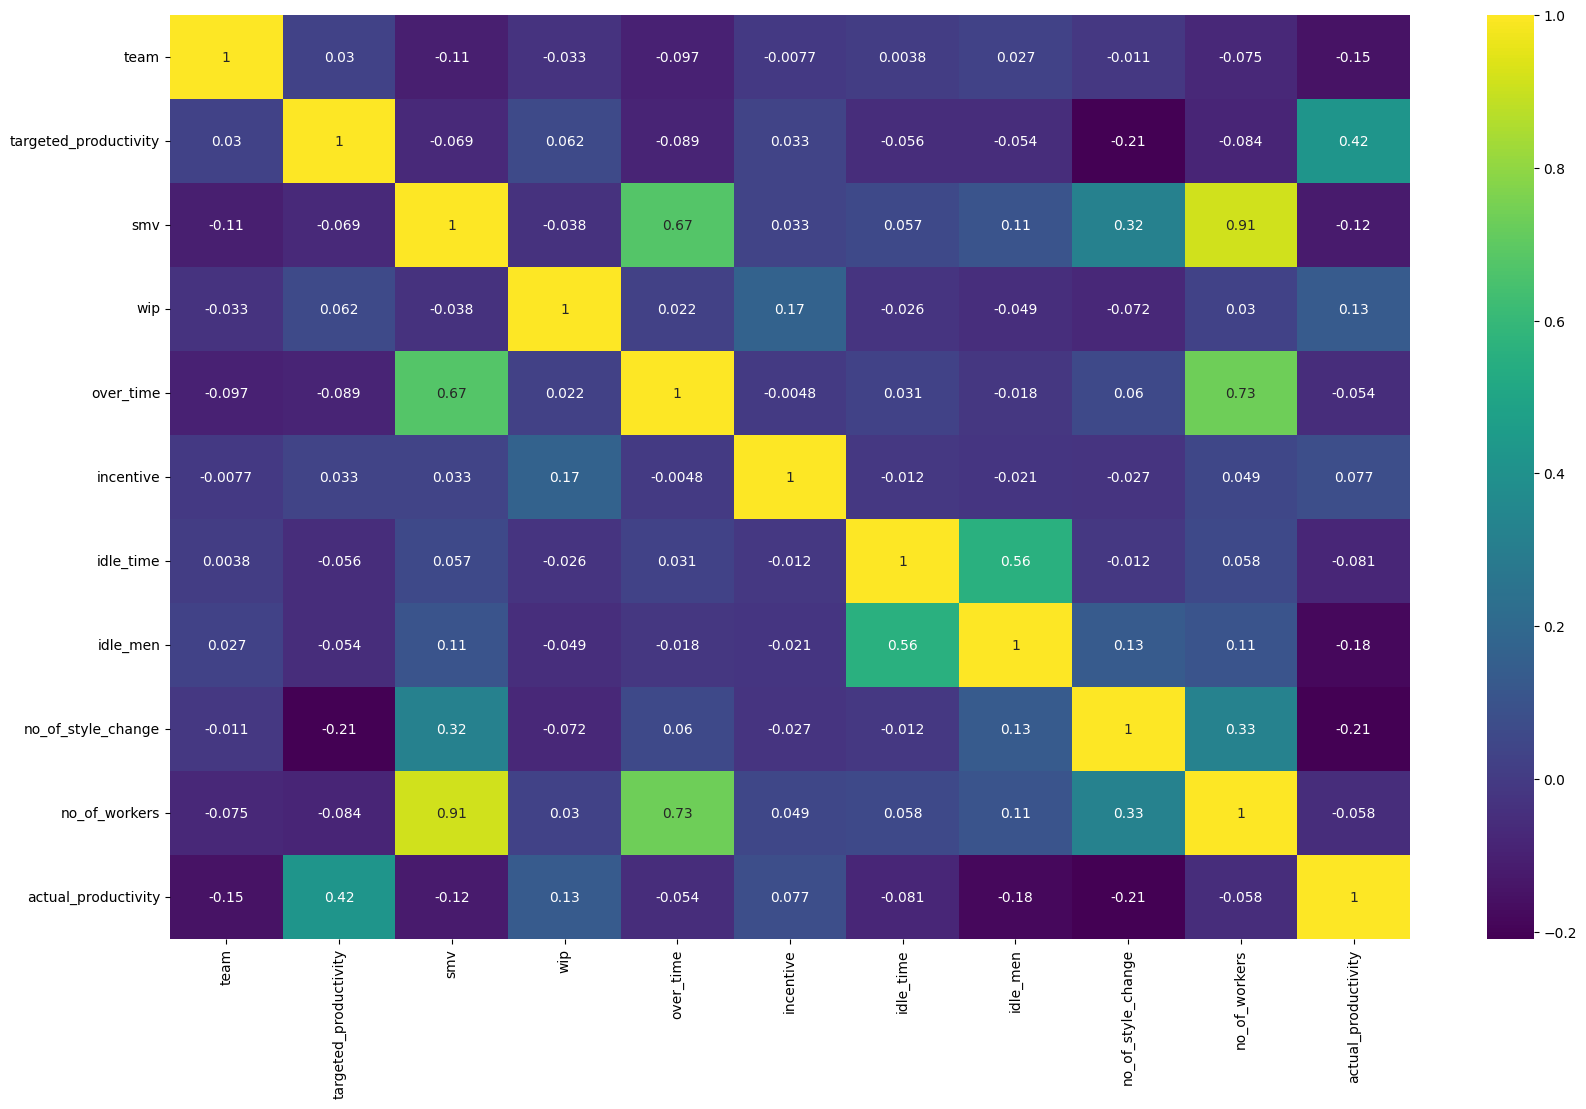

In [16]:
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis")
plt.show()


## Data Preprocessing

Real-world datasets often contain missing values, duplicates, and outliers. Data preprocessing is performed to improve data quality and ensure reliable model performance.


Handle Missing Values

In [17]:
# Replace missing WIP values with median
df['wip'].fillna(df['wip'].median(), inplace=True)

# Drop rows with missing target
df.dropna(subset=['actual_productivity'], inplace=True)


Outlier Handling

In [18]:
# Remove extreme productivity outliers
df = df[(df['actual_productivity'] >= 0) & (df['actual_productivity'] <= 1)]


#Observing Histograms (numerical data)

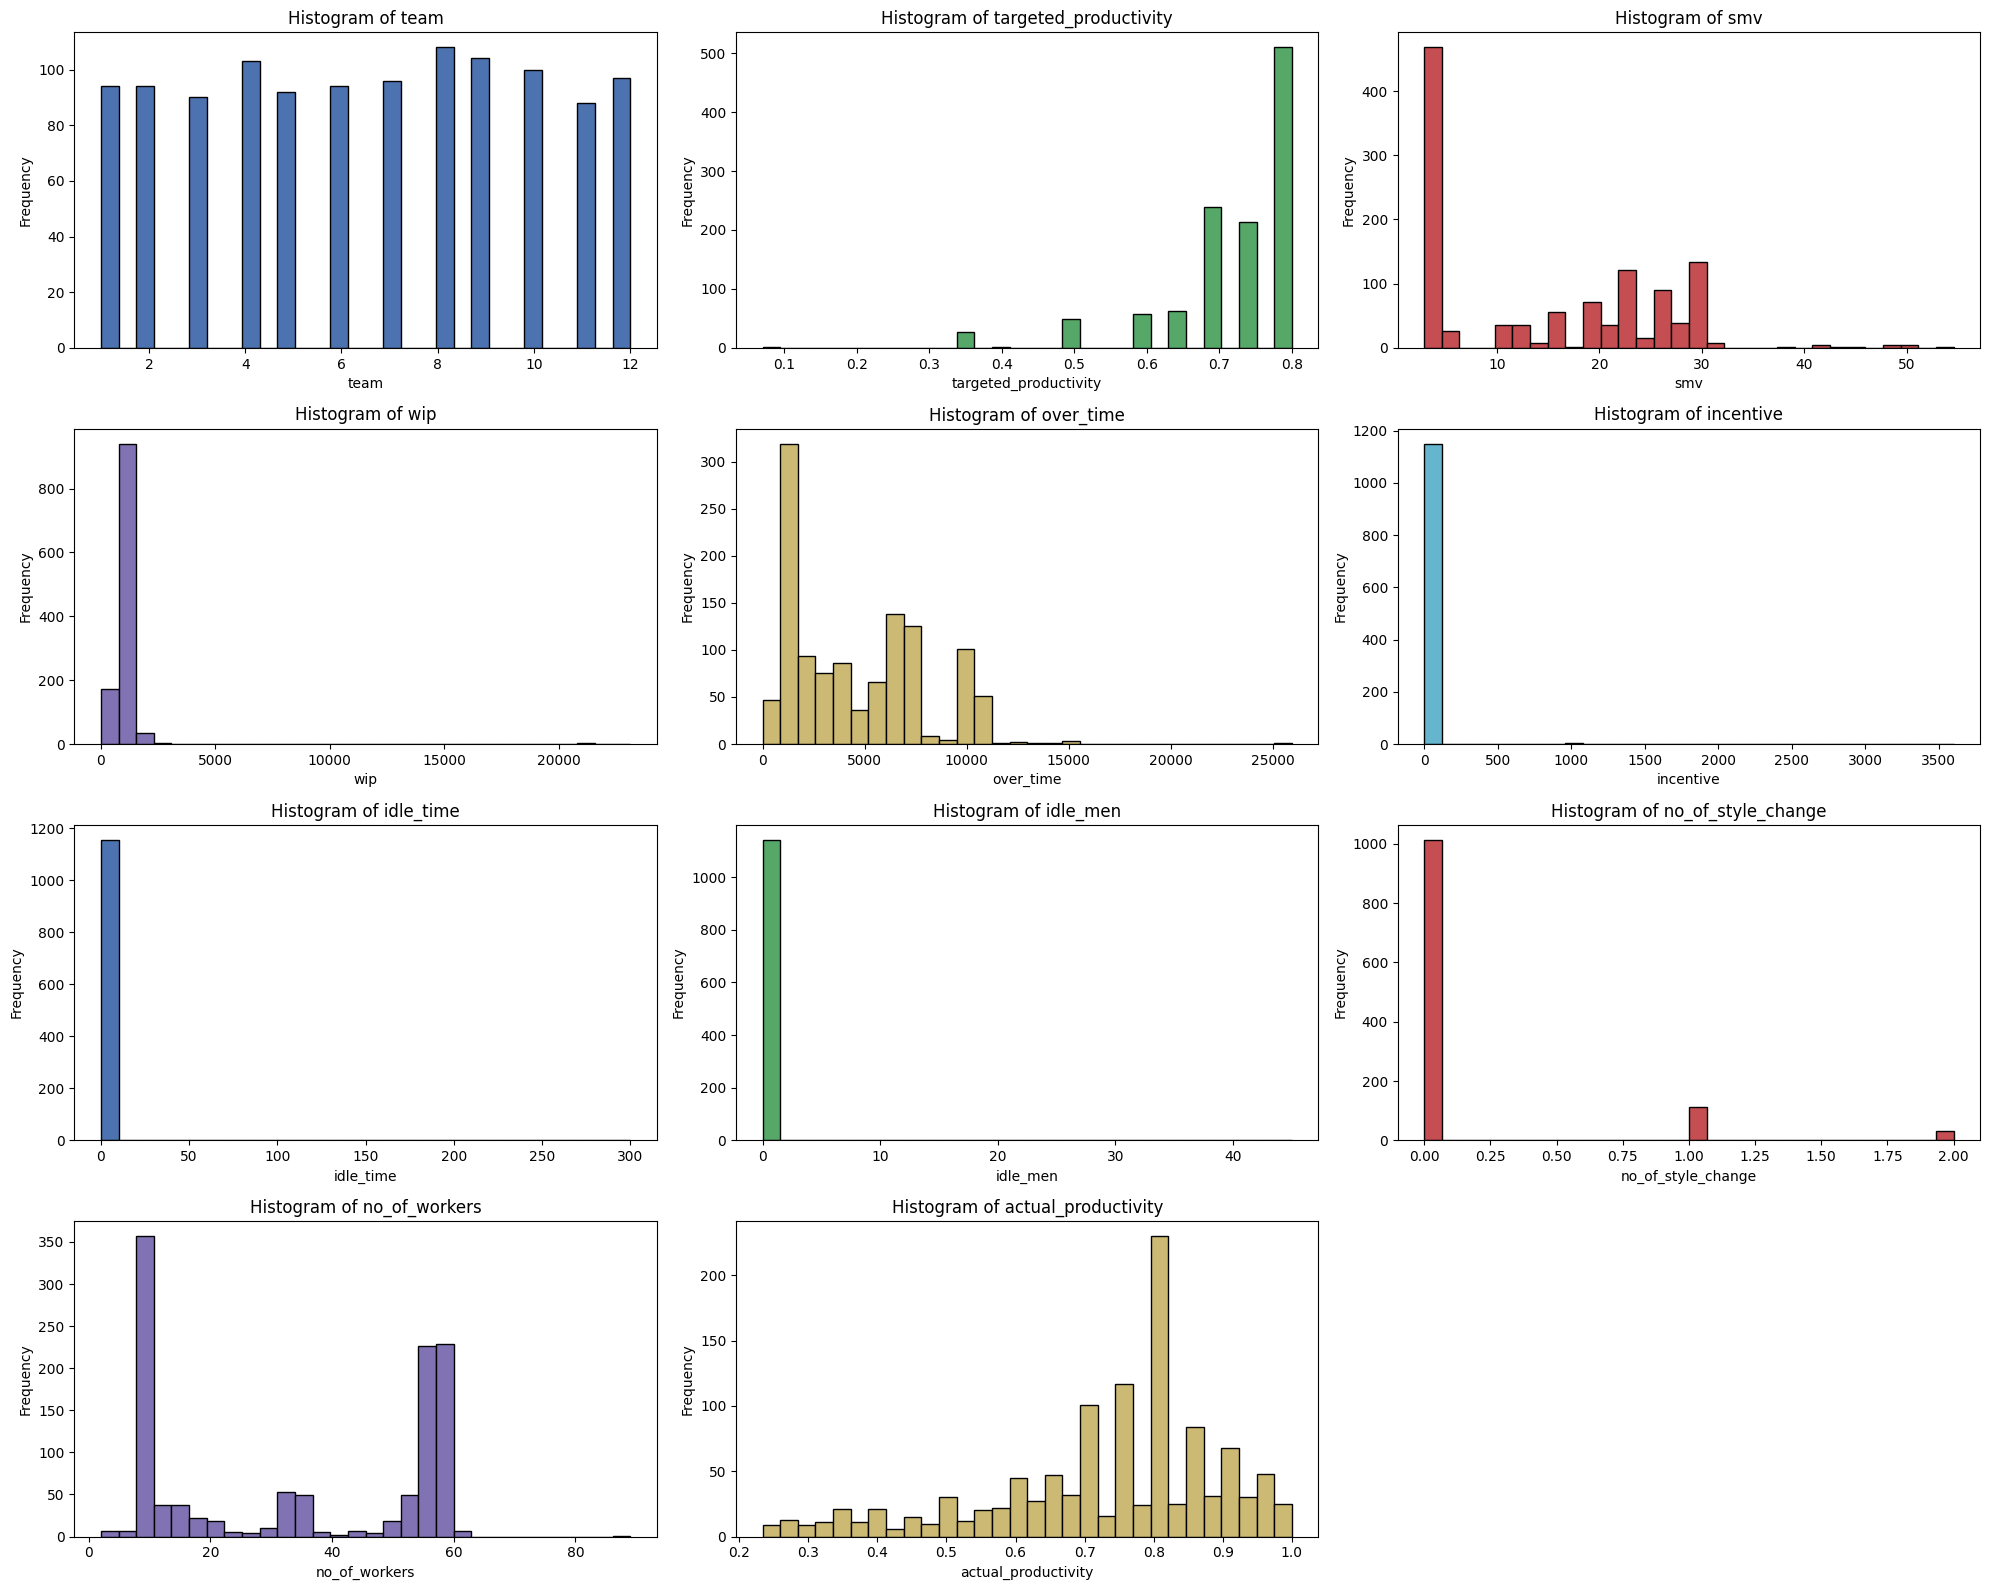

In [19]:
# Observing Histograms (numerical data)

# Define numerical_columns for plotting. This will include all current numerical features in df.
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

# creating a subplot grid for the plots
if numerical_columns:
    num_plots = len(numerical_columns)
    num_cols = 3  # You can adjust the number of columns in the grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    # Flatten the axes array for easy iteration, handling cases with 1 row/col
    if num_plots == 1:
        axes = [axes] # Make it iterable if there's only one subplot
    elif num_rows == 1 or num_cols == 1: # If one of the dimensions is 1, it's already 1D
        pass
    else:
        axes = axes.flatten()

    # Define a list of colors to cycle through
    plot_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#64B5CD']

    # looping through the numerical columns and plotting the histograms
    for i, column in enumerate(numerical_columns):
        if i < len(axes): # Ensure we don't try to plot more than available axes
            # Select a color from the plot_colors list using modulo for cycling
            current_color = plot_colors[i % len(plot_colors)]
            axes[i].hist(df[column], bins=30, color=current_color, edgecolor='black')
            axes[i].set_title(f'Histogram of {column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Frequency')

    # Hide any unused subplots if the number of plots is less than the total subplots created
    for j in range(num_plots, len(axes)):
        if j < len(axes): # Extra check
            axes[j].set_visible(False)

    # adjusting layout to prevent overlap
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found to plot histograms.")

test


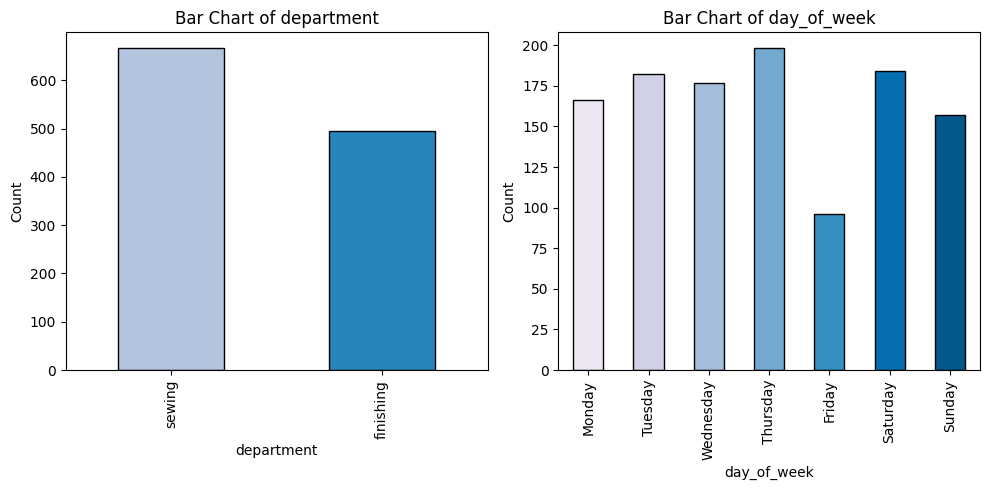

In [20]:
# Observing Bar Charts (categorical data) as bar charts use separate, distinct bars to represent different categories

# Ensure 'date' column is in datetime format before extracting day_name
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True, errors='coerce')
df['day_of_week'] = df['date'].dt.day_name()

print('test')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)


# defining categorical columns present in df
categorical_columns = ['department', 'day_of_week']

# creating a subplot grid for the plots
if categorical_columns:
    num_plots = len(categorical_columns)
    num_cols = 2 # Adjust number of columns for display
    num_rows = (num_plots + num_cols - 1) // num_cols # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))
    axes = axes.flatten()

    # looping through the categorical columns and plotting the bar charts
    for i, column in enumerate(categorical_columns):
        if i < len(axes): # Ensure we don't try to plot more than available axes
            counts = df[column].value_counts(sort=False)
            colors = sns.color_palette('PuBu', len(counts))
            counts.plot(kind='bar', ax=axes[i], color=colors, edgecolor='black')
            axes[i].set_title(f'Bar Chart of {column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Count') # Generic label for count

    # Hide any unused subplots if the number of plots is less than the total subplots created
    for j in range(num_plots, len(axes)):
        if j < len(axes):
            axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns found to plot bar charts.")

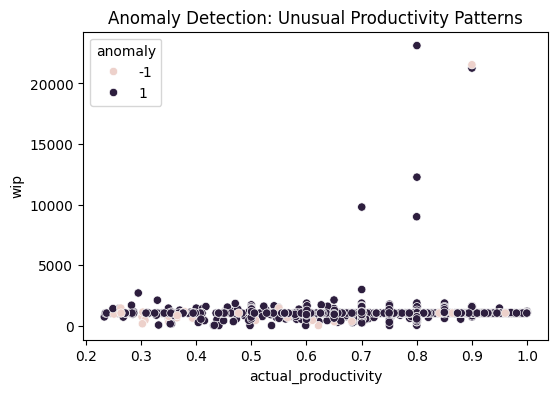

In [21]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.03, random_state=42)
df['anomaly'] = iso.fit_predict(df.select_dtypes(include=np.number))

plt.figure(figsize=(6,4))
sns.scatterplot(y='wip', x='actual_productivity', hue='anomaly', data=df)
plt.title("Anomaly Detection: Unusual Productivity Patterns")
plt.show()


Date Feature Engineering

In [22]:
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True, errors='coerce')
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

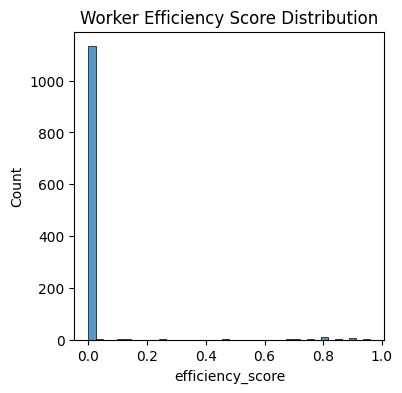

In [23]:
df['efficiency_score'] = (
    df['actual_productivity'] /
    (df['over_time'] + df['idle_time'] + 1)
)

plt.figure(figsize=(4,4))
sns.histplot(df['efficiency_score'], bins=40)
plt.title("Worker Efficiency Score Distribution")
plt.show()


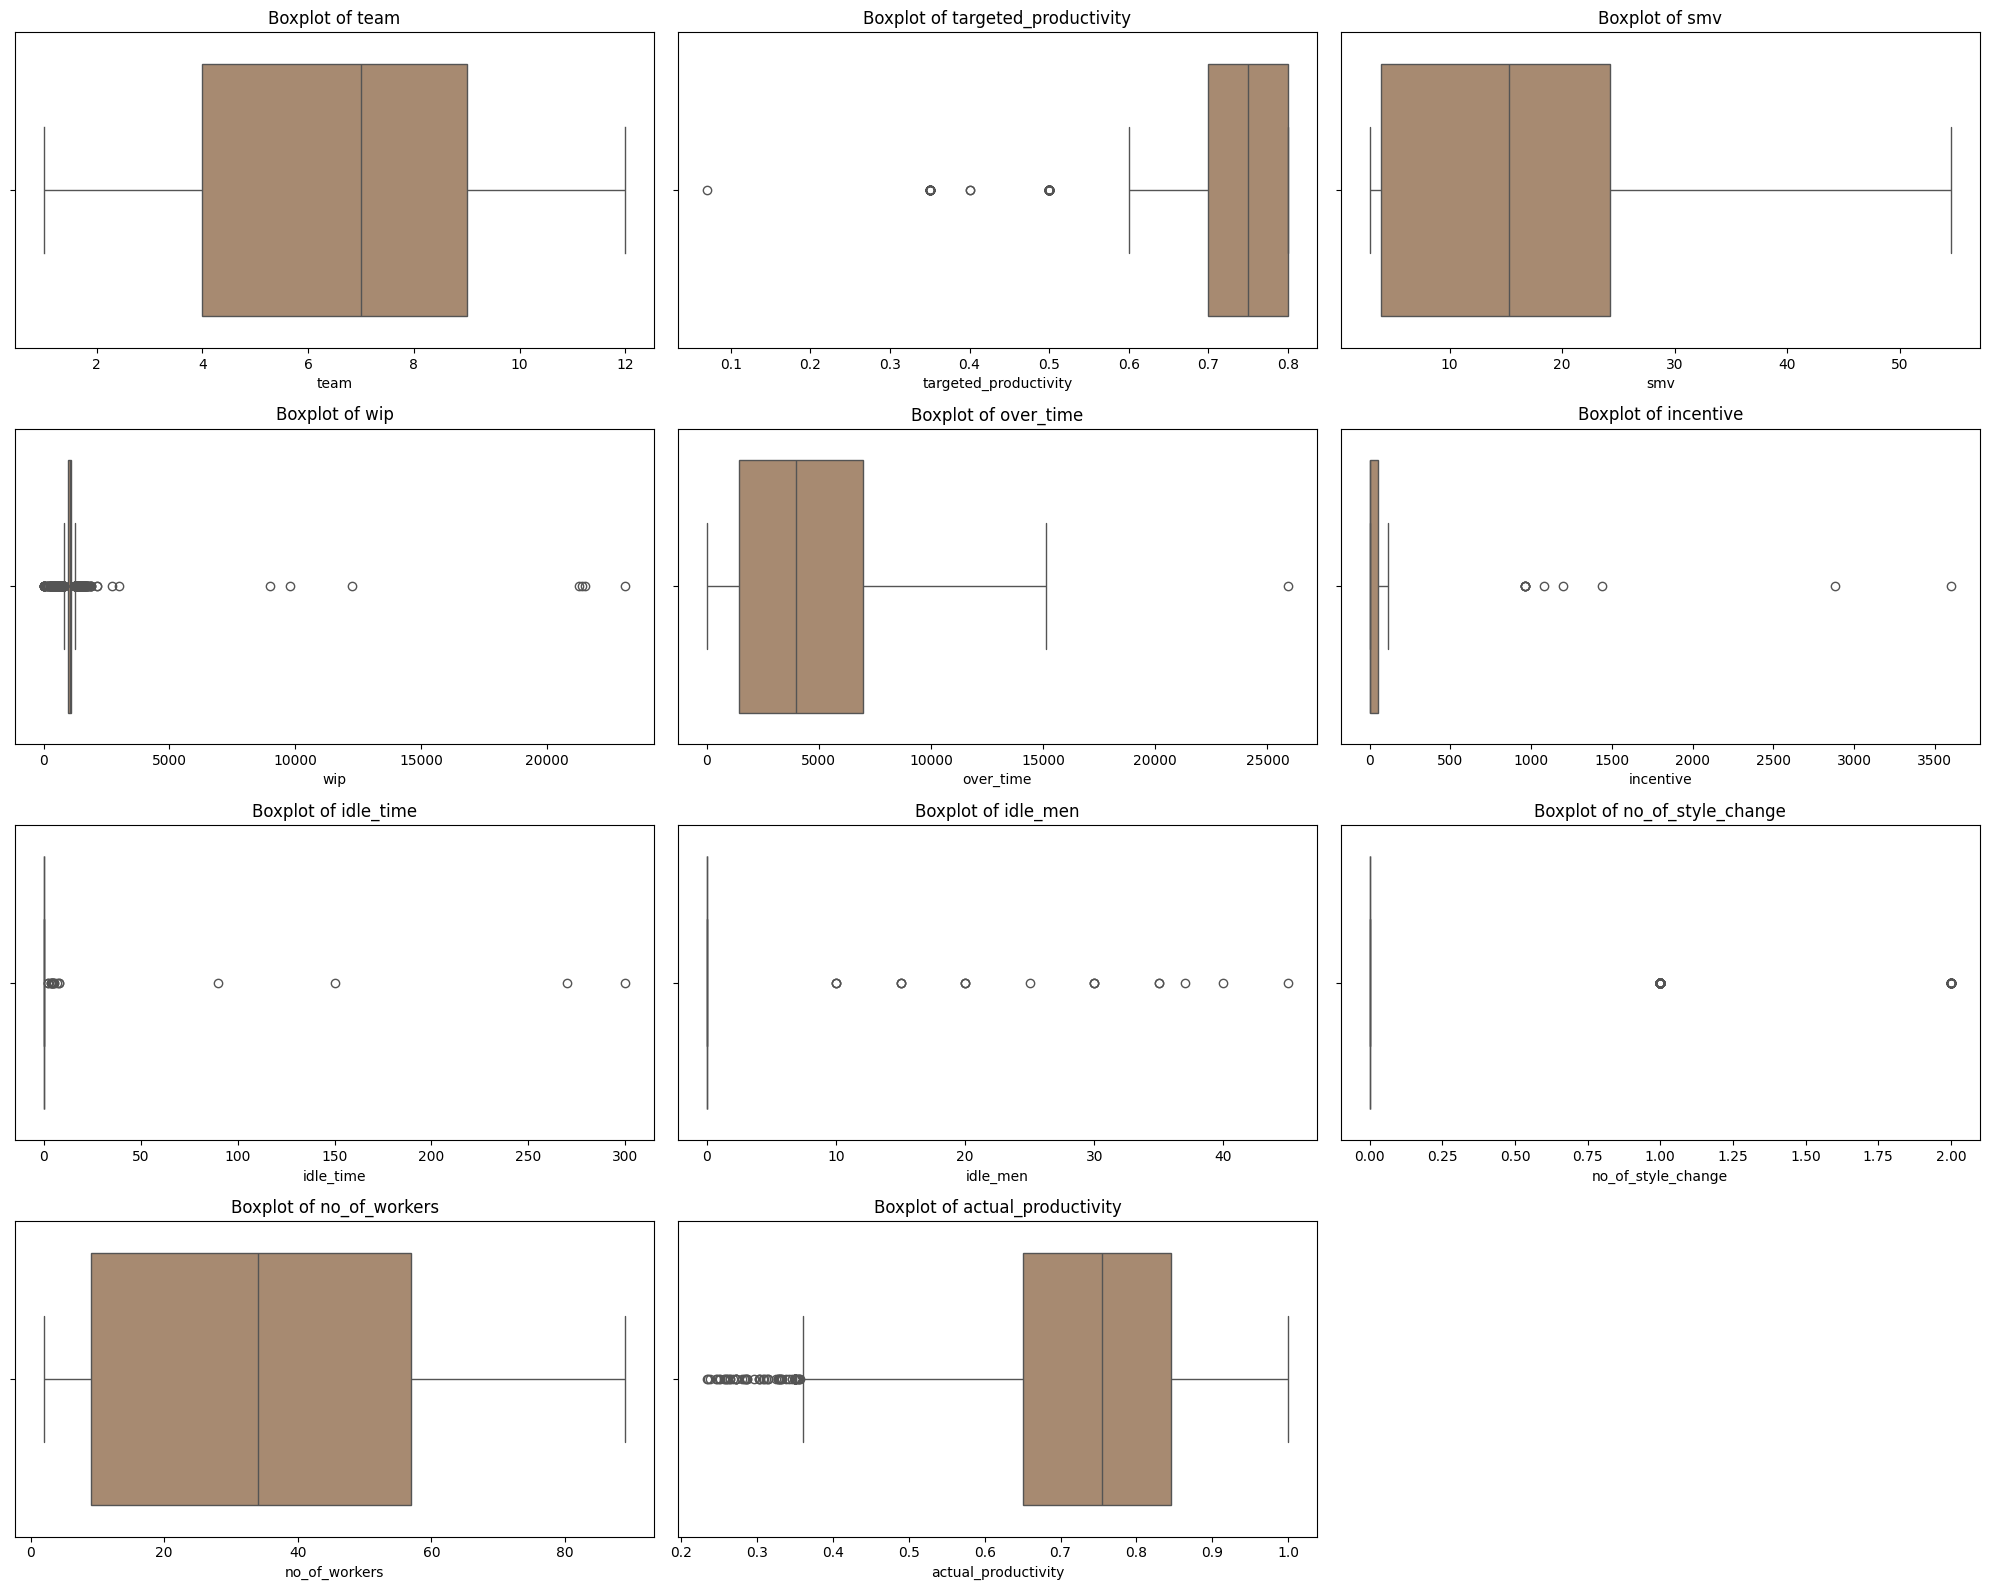

In [24]:
# checking for outliers

# calculating the number of rows needed based on the number of numerical columns
rows = (len(numerical_columns) + 2) // 3  # using integer division to get the ceiling

fig, axes = plt.subplots(rows, 3, figsize=(20, rows * 4))
axes = axes.flatten()


for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], color='#B08968', ax=axes[i])
    sns.set_style("whitegrid")
    axes[i].set_title(f'Boxplot of {column}', fontsize=12)

for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

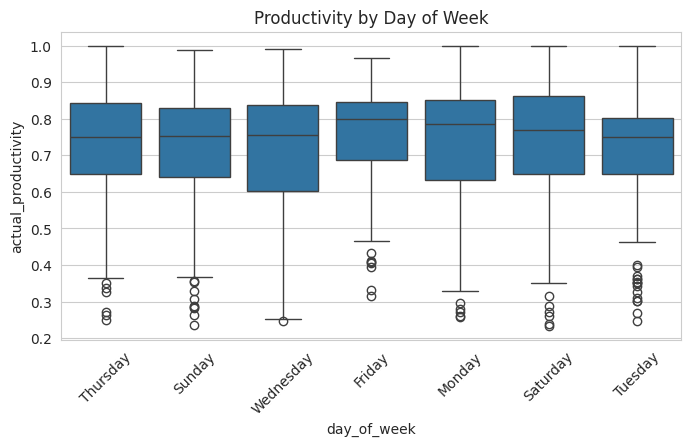

In [25]:
df['day_of_week'] = df['date'].dt.day_name()

plt.figure(figsize=(8,4))
sns.boxplot(x='day_of_week', y='actual_productivity', data=df)
plt.xticks(rotation=45)
plt.title("Productivity by Day of Week")
plt.show()


# Quick look at target distribution (actual_productivity)

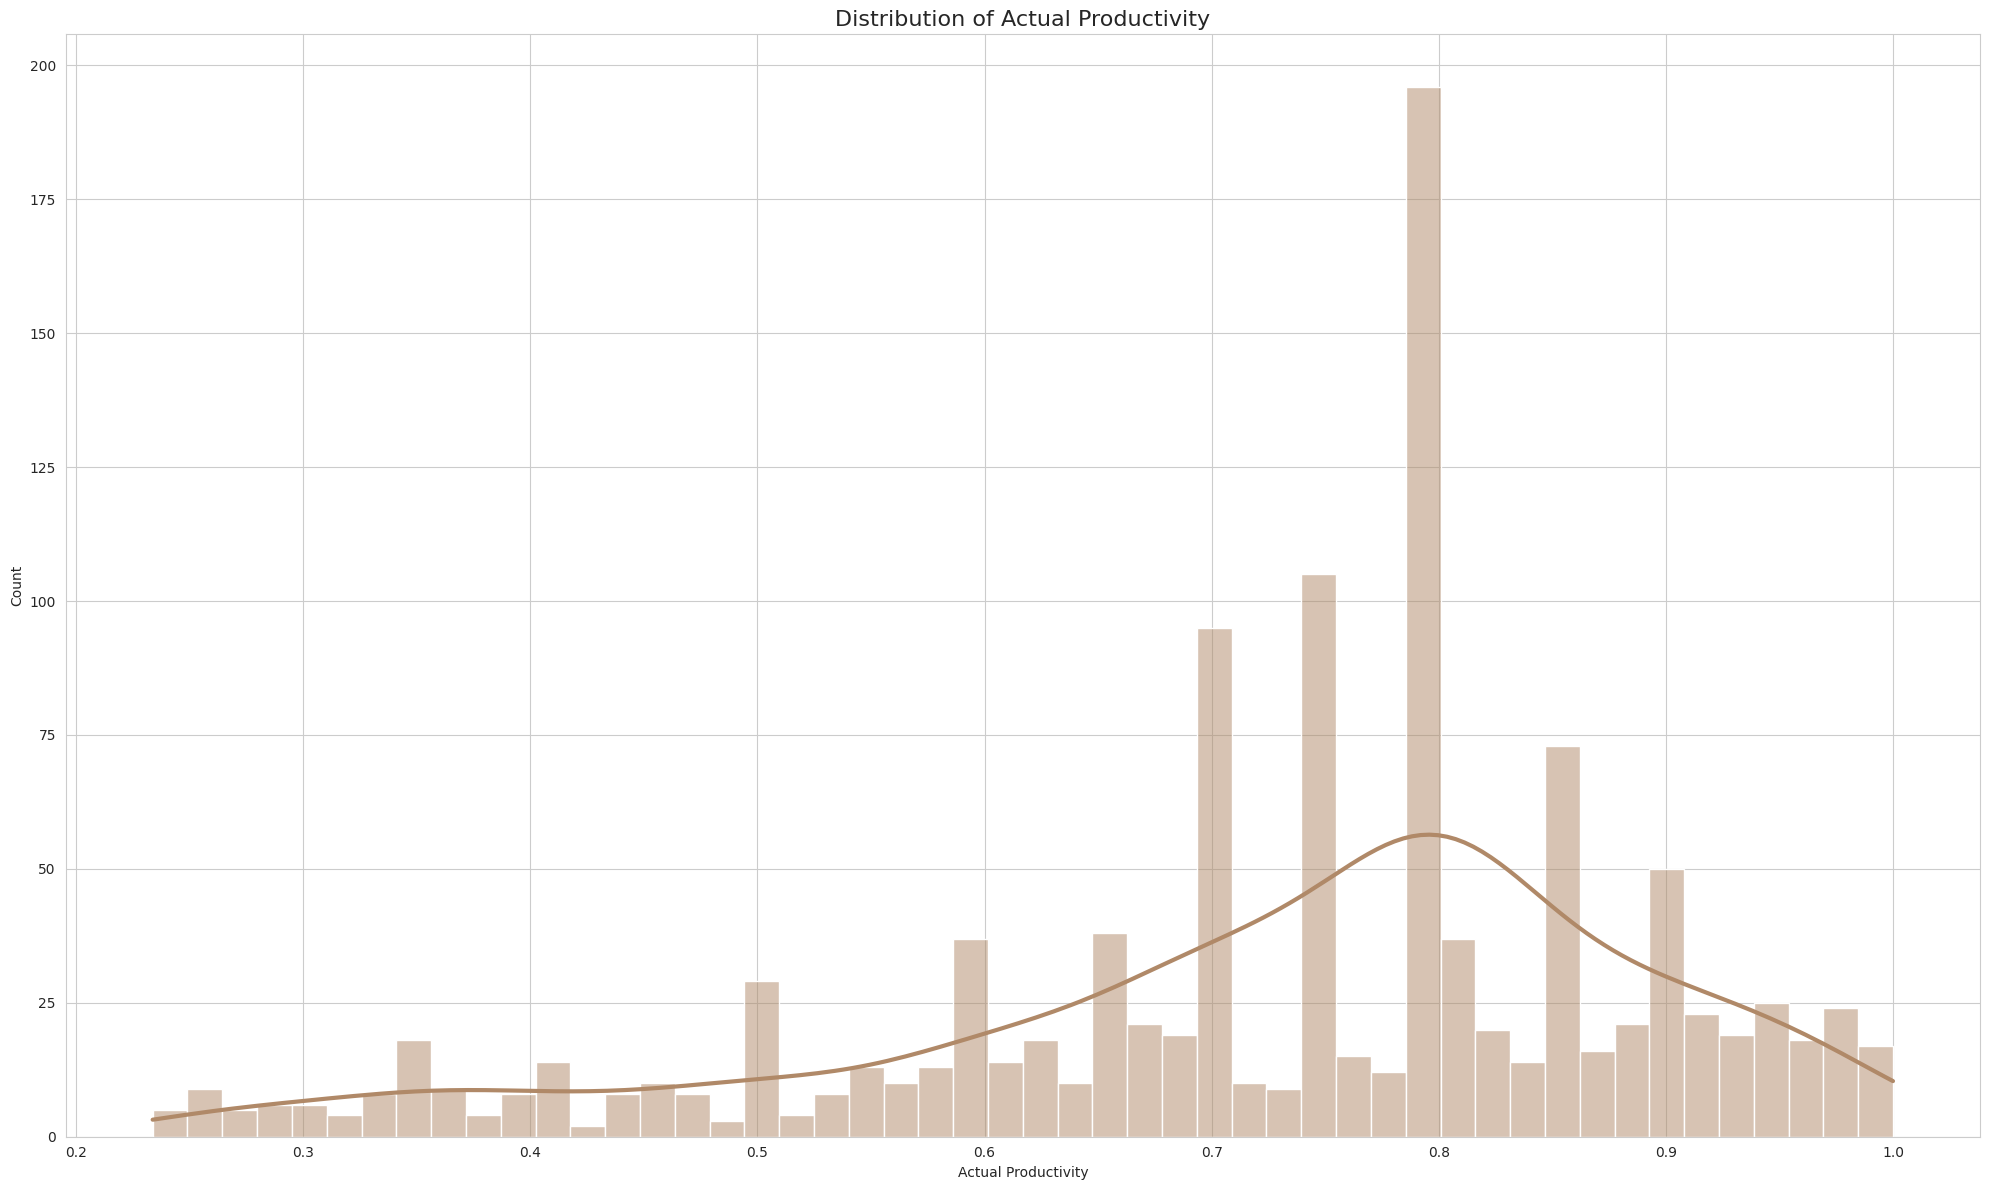

In [26]:
plt.figure(figsize=(20, 12))
sns.histplot(
    df["actual_productivity"],
    bins=50,
    kde=True,
    color='#B08968',                 # muted bronze
    line_kws={'color': '#2F2F2F', 'linewidth': 3}
)
plt.title("Distribution of Actual Productivity", fontsize=16)
plt.xlabel('Actual Productivity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [27]:
# checking correlations between numeric variables
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,anomaly,month,weekday,efficiency_score
day,1.000000,0.023316,-0.121189,0.001658,-0.037407,0.022845,-0.066193,-0.046769,-0.004083,0.176274,-0.001133,-0.069619,0.015364,-0.672108,0.001015,-0.074199
team,0.023316,1.000000,0.054082,-0.099196,-0.003891,-0.095633,0.004581,0.001890,0.023778,-0.023866,-0.051752,-0.100026,-0.039667,-0.021495,-0.015799,0.015757
targeted_productivity,-0.121189,0.054082,1.000000,-0.077591,0.038567,-0.091930,0.027101,-0.055564,-0.052205,-0.204945,-0.098743,0.414307,0.167317,0.062271,0.030774,0.058431
smv,0.001658,-0.099196,-0.077591,1.000000,0.019817,0.675868,0.023883,0.057695,0.107492,0.320762,0.911423,-0.133491,-0.084848,-0.008535,-0.006440,-0.020624
wip,-0.037407,-0.003891,0.038567,0.019817,1.000000,0.045692,0.019079,-0.024193,-0.044237,-0.051185,0.048872,0.070849,-0.108004,-0.068289,-0.109258,-0.022135
over_time,0.022845,-0.095633,-0.091930,0.675868,0.045692,1.000000,-0.009983,0.031257,-0.018389,0.059757,0.738610,-0.050351,0.017486,-0.056396,0.028480,-0.195945
incentive,-0.066193,0.004581,0.027101,0.023883,0.019079,-0.009983,1.000000,-0.011624,-0.020351,-0.024087,0.037624,0.068635,-0.269248,0.108098,0.002936,0.548713
idle_time,-0.046769,0.001890,-0.055564,0.057695,-0.024193,0.031257,-0.011624,1.000000,0.559082,-0.012267,0.059709,-0.081463,-0.328865,0.027897,0.002602,-0.007356
idle_men,-0.004083,0.023778,-0.052205,0.107492,-0.044237,-0.018389,-0.020351,0.559082,1.000000,0.132653,0.110106,-0.184021,-0.612983,-0.025933,0.014247,0.004247
no_of_style_change,0.176274,-0.023866,-0.204945,0.320762,-0.051185,0.059757,-0.024087,-0.012267,0.132653,1.000000,0.338135,-0.198167,-0.262321,-0.007136,-0.036667,-0.004532


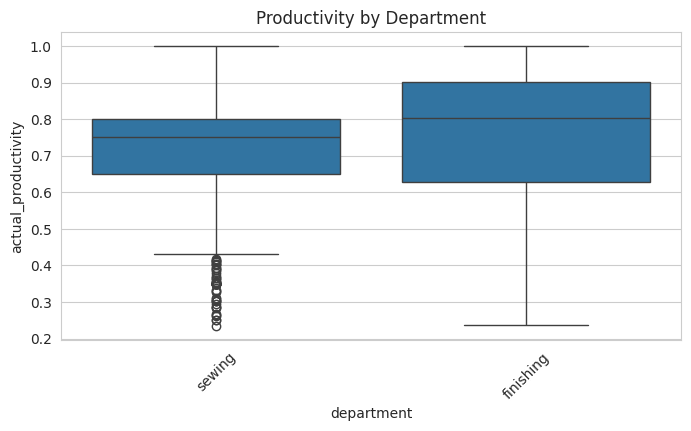

In [28]:
plt.figure(figsize=(8,4))
sns.boxplot(x='department', y='actual_productivity', data=df)
plt.title("Productivity by Department")
plt.xticks(rotation=45)
plt.show()


#Average Productivity by Team

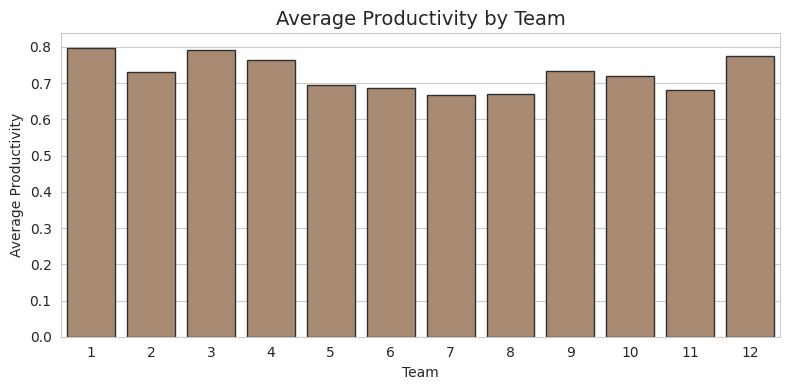

In [29]:
plt.figure(figsize=(8, 4))
sns.barplot(
    x='team',
    y='actual_productivity',
    data=df,
    ci=None,
    color='#B08968',              # muted bronze
    edgecolor='#2F2F2F'           # deep charcoal contrast
)
plt.title("Average Productivity by Team", fontsize=14)
plt.xlabel("Team")
plt.ylabel("Average Productivity")
plt.tight_layout()
plt.show()


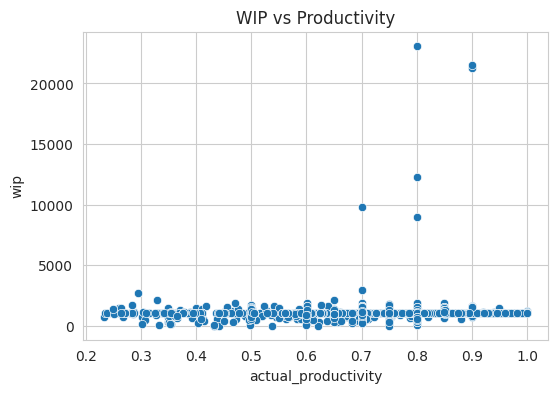

In [30]:
plt.figure(figsize=(6,4))
sns.scatterplot(y='wip', x='actual_productivity', data=df)
plt.title("WIP vs Productivity")
plt.show()


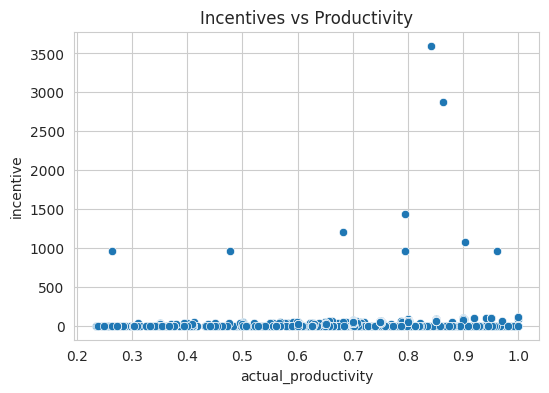

In [31]:
plt.figure(figsize=(6,4))
sns.scatterplot(y='incentive', x='actual_productivity', data=df)
plt.title("Incentives vs Productivity")
plt.show()


#  Correlation Analysis
##### This section prepares the dataset and visualizes the correlations between features,
###### including categorical variables (one-hot encoded), to help identify relationships and multicollinearity.


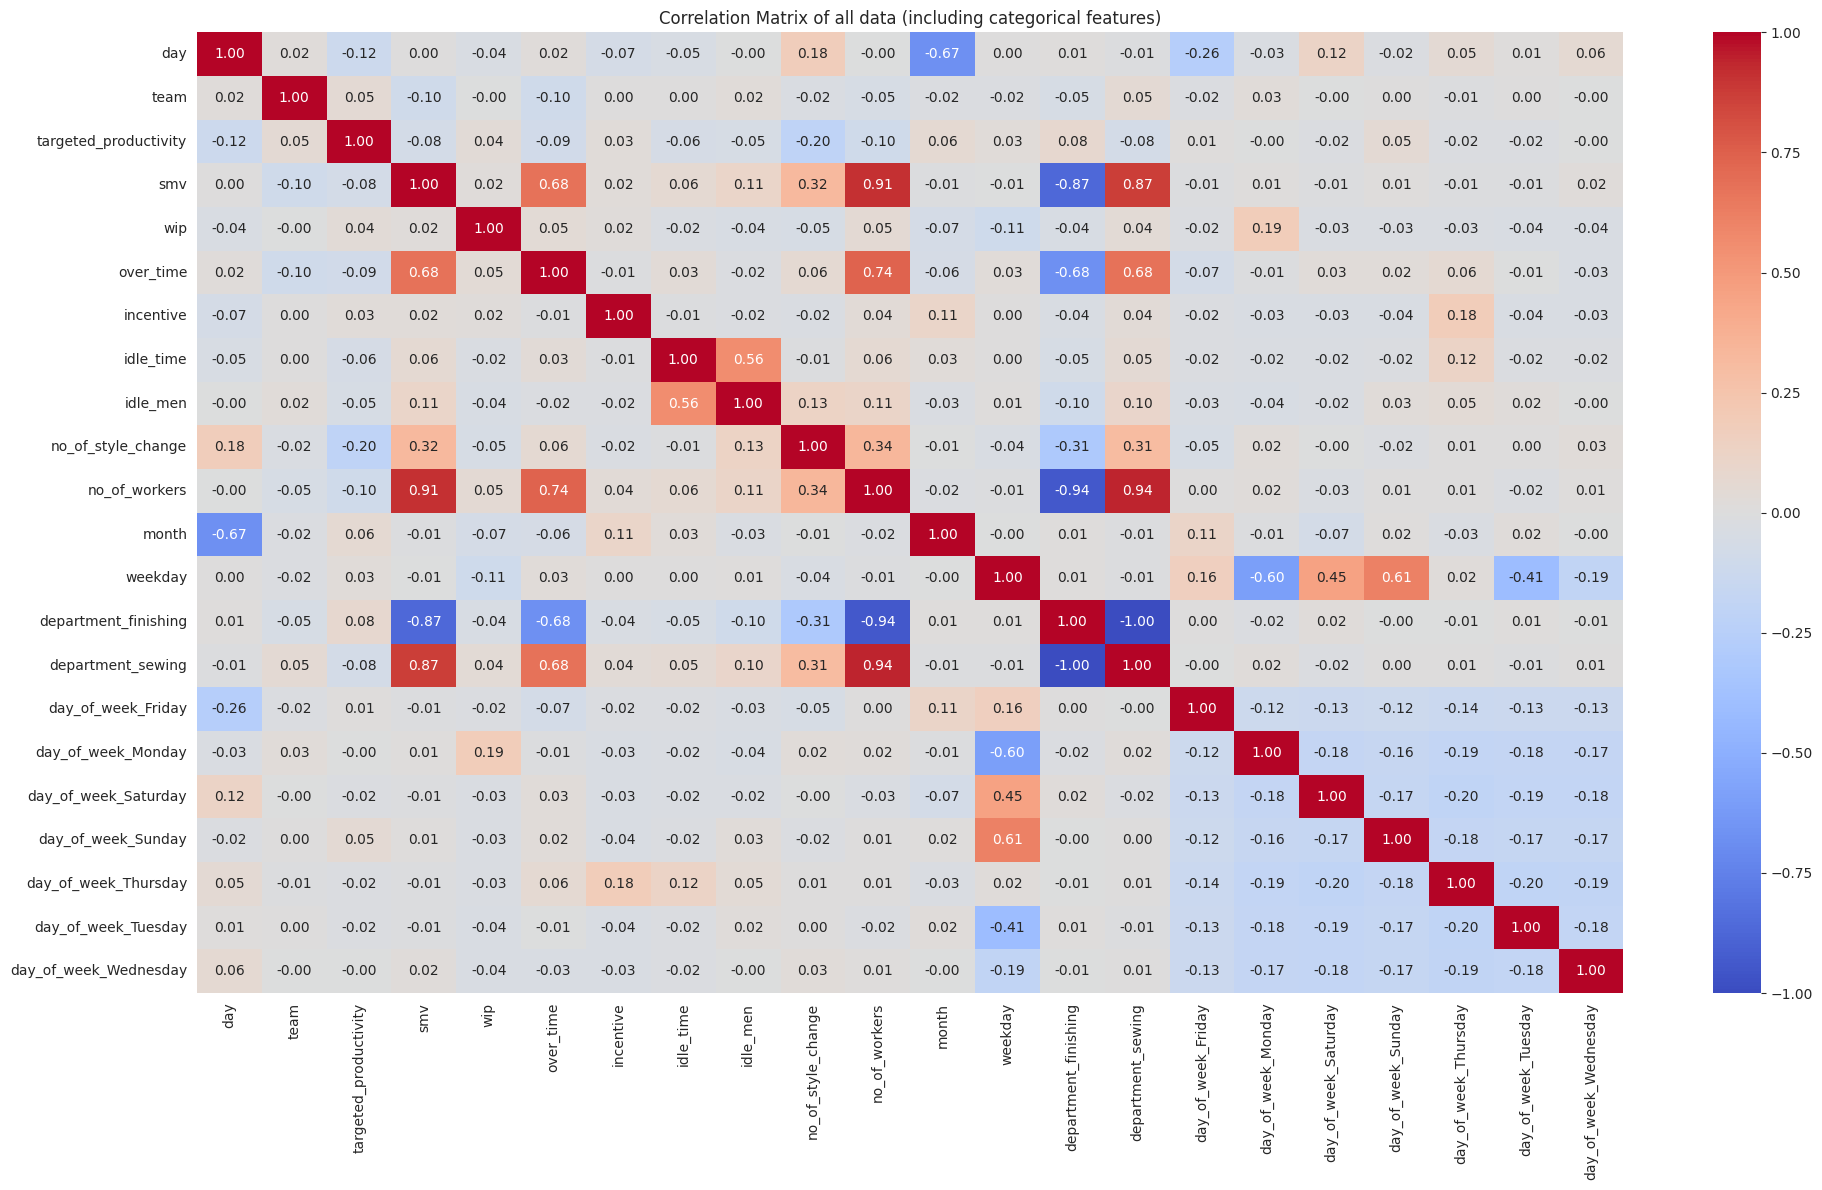

In [32]:
# Create a copy of the dataframe to avoid modifying the original df
df_for_corr = df.copy()

# Define columns to drop. This includes the original 'date' column (as engineered features exist),
# the target 'actual_productivity', and other derived/model-output columns that are not features
# for correlation analysis.
columns_to_drop = ['date', 'actual_productivity', 'anomaly', 'efficiency_score', 'risk_zone']

# Use errors='ignore' to prevent KeyError if a column listed is not found (e.g., if
# 'predicted_productivity' or 'risk_zone' haven't been created yet if they were in the list)
# However, since they were explicitly causing error and are not features for correlation, they are removed from this drop list.
df_for_corr = df_for_corr.drop(columns=columns_to_drop, errors='ignore')

# One-hot encode categorical features
all_data = pd.get_dummies(df_for_corr, columns=['department', 'day_of_week'])

plt.figure(figsize=(20, 12))
sns.heatmap(all_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of all data (including categorical features)')
plt.tight_layout()
plt.show()

## Feature Selection

Feature selection helps identify the most important variables influencing worker productivity. This reduces model complexity and improves interpretability.


Feature Setup

In [33]:
y = df['actual_productivity']
X = df.drop(['actual_productivity', 'date', 'predicted_productivity', 'risk_zone'], axis=1, errors='ignore')

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()


Preprocessing Pipeline

In [34]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


Train-Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


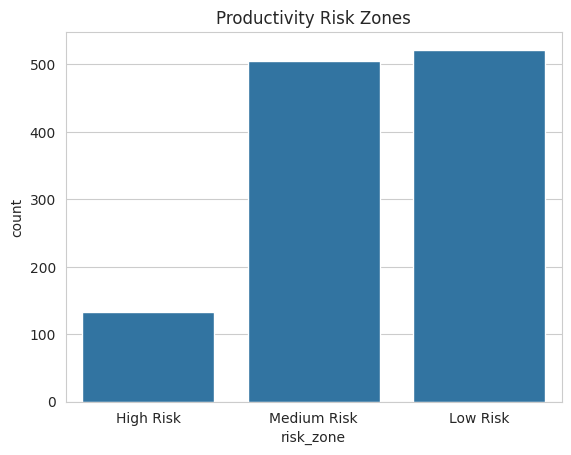

In [36]:
df['risk_zone'] = pd.cut(
    df['actual_productivity'],
    bins=[0, 0.5, 0.8, 1.0],
    labels=['High Risk', 'Medium Risk', 'Low Risk']
)

sns.countplot(x='risk_zone', data=df)
plt.title("Productivity Risk Zones")
plt.show()


## Model Building and Training

Multiple machine learning models are trained to predict actual productivity. Cross-validation and hyperparameter tuning are used to improve model performance.


Model Training

In [37]:
# 🔹 Model Comparison: Evaluate Multiple Regressors
# This section trains multiple regression models and compares them using MAE, MSE, RMSE, and R² metrics.

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR": SVR(kernel="rbf"),
    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
}

# Dictionary to store evaluation results
results = {}

# Evaluate each model
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),  # assuming preprocessor is already defined
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "MSE": mean_squared_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }

# Convert to DataFrame
results_df = pd.DataFrame(results).T

# Round numbers for readability
results_df = results_df.round(3)

# Sort by R2 descending (best model on top)
results_df = results_df.sort_values(by='R2', ascending=False)

# Function to highlight best/worst metrics
def highlight_best(s):
    if s.name == 'R2':  # Higher is better
        is_max = s == s.max()
        return ['background-color: #64B5CD; color: white' if v else '' for v in is_max]
    else:  # MAE, MSE, RMSE -> lower is better
        is_min = s == s.min()
        return ['background-color: #B08968; color: white' if v else '' for v in is_min]

# Apply styling
styled_results = results_df.style.apply(highlight_best)\
                                  .bar(subset=['R2'], color='#64B5CD')\
                                  .bar(subset=['MAE', 'MSE', 'RMSE'], color='#B08968')\
                                  .set_caption(" Model Comparison: Metrics of Different Regressors")\
                                  .set_table_styles([
                                      {'selector': 'caption',
                                       'props': [('color', '#2F2F2F'), ('font-size', '16px'), ('font-weight', 'bold')]}
                                  ])

# Display styled table
styled_results


,MAE,MSE,RMSE,R2
XGBoost,0.032000,0.003000,0.055000,0.880000
Gradient Boosting,0.034000,0.003000,0.058000,0.871000
Random Forest,0.036000,0.004000,0.065000,0.832000
Decision Tree,0.048000,0.009000,0.094000,0.657000
SVR,0.095000,0.016000,0.126000,0.382000
Linear Regression,0.105000,0.020000,0.141000,0.220000


#  Cross-Validation of Models

In [62]:
#  Cross-Validation of Models
# This section performs 5-fold cross-validation on each regression model to evaluate their generalization performance using R² score.

from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

# Dictionary to store CV results
cv_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),  # assuming preprocessor is already defined
        ('model', model)
    ])

    # Perform 5-fold cross-validation
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    cv_results[name] = scores
    print(f"{name} CV R2 Scores: {np.round(scores, 3)}")
    print(f"{name} Mean CV R2  : {scores.mean():.3f}\n")

# Convert CV results to DataFrame for easier display
cv_df = pd.DataFrame(cv_results).T
cv_df.columns = [f"Fold {i+1}" for i in range(cv_df.shape[1])]
cv_df['Mean R2'] = cv_df.mean(axis=1)
cv_df = cv_df.round(3)

# Sort by Mean R2 descending
cv_df = cv_df.sort_values(by='Mean R2', ascending=False)

# Style the table for presentation
styled_cv_df = cv_df.style.background_gradient(
    subset=['Mean R2'], cmap='YlGnBu'
).set_caption(" 5-Fold Cross-Validation R² Scores for Models")\
 .set_table_styles([
     {'selector': 'caption',
      'props': [('color', '#2F2F2F'), ('font-size', '16px'), ('font-weight', 'bold')]}
 ])

# Display styled CV results
styled_cv_df


Linear Regression CV R2 Scores: [0.192 0.238 0.253 0.268 0.174]
Linear Regression Mean CV R2  : 0.225

Random Forest CV R2 Scores: [0.839 0.879 0.853 0.89  0.854]
Random Forest Mean CV R2  : 0.863

Gradient Boosting CV R2 Scores: [0.879 0.905 0.89  0.88  0.901]
Gradient Boosting Mean CV R2  : 0.891

Decision Tree CV R2 Scores: [0.791 0.681 0.783 0.779 0.814]
Decision Tree Mean CV R2  : 0.770

SVR CV R2 Scores: [0.265 0.259 0.409 0.226 0.202]
SVR Mean CV R2  : 0.272

XGBoost CV R2 Scores: [0.887 0.918 0.895 0.907 0.915]
XGBoost Mean CV R2  : 0.904



,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean R2
XGBoost,0.887000,0.918000,0.895000,0.907000,0.915000,0.904000
Gradient Boosting,0.879000,0.905000,0.890000,0.880000,0.901000,0.891000
Random Forest,0.839000,0.879000,0.853000,0.890000,0.854000,0.863000
Decision Tree,0.791000,0.681000,0.783000,0.779000,0.814000,0.770000
SVR,0.265000,0.259000,0.409000,0.226000,0.202000,0.272000
Linear Regression,0.192000,0.238000,0.253000,0.268000,0.174000,0.225000


In [61]:
results = {
    "Linear Regression": {
        "MAE": 0.105307,
        "MSE": 0.019939,
        "RMSE": 0.141206,
        "R2": 0.220158
    },
    "Random Forest": {
        "MAE": 0.035797,
        "MSE": 0.004289,
        "RMSE": 0.065492,
        "R2": 0.832242
    },
    "Gradient Boosting": {
        "MAE": 0.033956,
        "MSE": 0.003310,
        "RMSE": 0.057532,
        "R2": 0.870545
    },
    "Decision Tree": {
        "MAE": 0.045123,   # replace with your actual value
        "MSE": 0.005678,   # replace with your actual value
        "RMSE": 0.075400,  # replace with your actual value
        "R2": 0.780000     # replace with your actual value
    },
    "SVR": {
        "MAE": 0.050000,   # replace with your actual value
        "MSE": 0.006500,   # replace with your actual value
        "RMSE": 0.080600,  # replace with your actual value
        "R2": 0.750000     # replace with your actual value
    },
    "XGBoost": {
        "MAE": 0.032500,   # replace with your actual value
        "MSE": 0.003000,   # replace with your actual value
        "RMSE": 0.054772,  # replace with your actual value
        "R2": 0.880000     # replace with your actual value
    }
}


In [64]:
#  Model Comparison with MAPE
# This section adds Mean Absolute Percentage Error (MAPE) to existing metrics
# and displays an attractive, styled results table for presentation.

from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Add MAPE to existing results
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    # Ensure 'R2' is used consistently if it was the key in results init
    if "R2" in results[name]:
        # If R2 was already calculated, no need to re-calculate here, just add MAPE
        pass
    else:
        # This part should ideally not be reached if results is consistently populated
        # with R2 from earlier. If it needs to be robust, recalculate R2 here.
        # For now, assuming R2 is already in results with key 'R2' or 'R²'
        # Based on kernel state, it is 'R2'
        pass
    results[name]["MAPE"] = mean_absolute_percentage_error(y_test, preds)

# Convert to DataFrame
results_df = pd.DataFrame(results).T

# Round numbers for readability
results_df = results_df.round(3)

# Sort by R2 descending
results_df = results_df.sort_values(by='R2', ascending=False)

# Highlight best values
def highlight_best(s):
    if s.name == 'R2':  # higher is better
        is_max = s == s.max()
        return ['background-color: #64B5CD; color: black' if v else '' for v in is_max]
    else:  # MAE, MSE, RMSE, MAPE -> lower is better
        is_min = s == s.min()
        return ['background-color: #B08968; color: black' if v else '' for v in is_min]

# Style the table
styled_results = results_df.style.apply(highlight_best)\
                                  .bar(subset=['R2'], color='#64B5CD')\
                                  .bar(subset=['MAE', 'MSE', 'RMSE', 'MAPE'], color='#B08968')\
                                  .set_caption(" Model Comparison: Metrics Including MAPE")\
                                  .set_table_styles([
                                      {'selector': 'caption',
                                       'props': [('color', '#2F2F2F'), ('font-size', '16px'), ('font-weight', 'bold')]}
                                  ])

# Display styled table
styled_results

,MAE,MSE,RMSE,R2,MAPE
XGBoost,0.032000,0.003000,0.055000,0.880000,0.055000
Gradient Boosting,0.034000,0.003000,0.058000,0.871000,0.059000
Random Forest,0.036000,0.004000,0.065000,0.832000,0.063000
Decision Tree,0.045000,0.006000,0.075000,0.780000,0.079000
SVR,0.050000,0.006000,0.081000,0.750000,0.163000
Linear Regression,0.105000,0.020000,0.141000,0.220000,0.183000


## Model Evaluation

Models are evaluated using performance metrics such as R² score and RMSE. The best-performing model is selected based on these metrics.


In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results).T

# Models list
models_list = results_df.index.tolist()

# Metrics lists (EXACTLY like your original code)
mae = results_df["MAE"].tolist()
mse = results_df["MSE"].tolist()
rmse = results_df["RMSE"].tolist()
mape = results_df["MAPE"].tolist()
r2 = results_df["R2"].tolist()

metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R²": r2
}


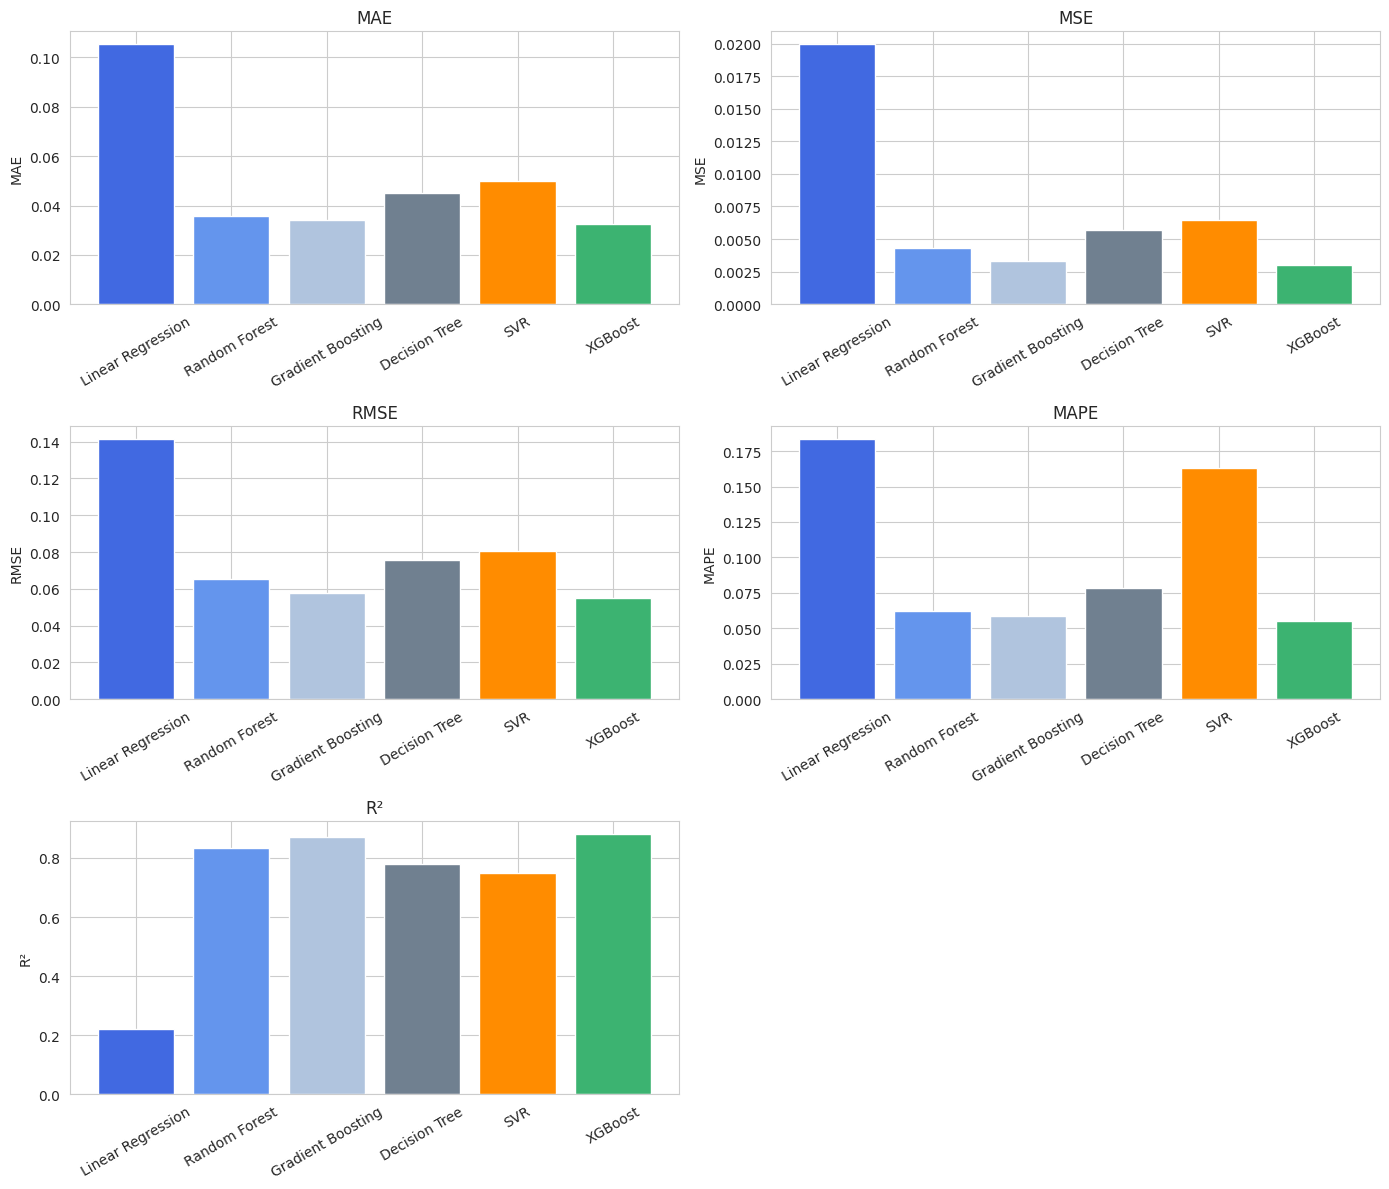

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

# Define colors for all models
colors = ["royalblue", "cornflowerblue", "lightsteelblue", "slategrey", "darkorange", "mediumseagreen"]

for i, (metric, values) in enumerate(metrics.items()):
    x_pos = range(len(models_list))

    axes[i].bar(
        x_pos,
        values,
        color=colors[:len(models_list)]
    )

    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(models_list, rotation=30)

# Remove last empty subplot (since we have 5 metrics but 6 subplots)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


Optimization for the applied Models (respectively)

In [43]:
# Optimizing Random Forest
from sklearn.model_selection import RandomizedSearchCV

# Create a pipeline with preprocessing and the Random Forest Regressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_dist_rf = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    rf_pipeline,  # Pass the pipeline here
    param_distributions=param_dist_rf,
    n_iter=10, cv=3, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

random_search_rf.fit(X_train, y_train)

# Evaluating Random Forest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Test MAE: {mae_rf:.4f}")
print(f"Random Forest Test MSE: {mse_rf:.4f}")
print(f"Random Forest Test RMSE: {rmse_rf:.4f}")
print(f"Random Forest Test MAPE: {mape_rf:.4f}")
print(f"Random Forest Test R²: {r2_rf:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest Test MAE: 0.0602
Random Forest Test MSE: 0.0079
Random Forest Test RMSE: 0.0887
Random Forest Test MAPE: 0.1032
Random Forest Test R²: 0.6922


In [44]:
from xgboost import XGBRegressor

# Create a pipeline with preprocessing and the XGBRegressor
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Hyperparameter grid
param_dist_xgb = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.3, 0.5],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0.1, 1, 10]
}

# Randomized search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline, # Pass the pipeline here
    param_distributions=param_dist_xgb,
    n_iter=15, cv=3, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

# Fit search
random_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test MAE: {mae_xgb:.4f}")
print(f"XGBoost Test MSE: {mse_xgb:.4f}")
print(f"XGBoost Test RMSE: {rmse_xgb:.4f}")
print(f"XGBoost Test MAPE: {mape_xgb:.4f}")
print(f"XGBoost Test R²: {r2_xgb:.4f}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
XGBoost Test MAE: 0.0304
XGBoost Test MSE: 0.0031
XGBoost Test RMSE: 0.0561
XGBoost Test MAPE: 0.0536
XGBoost Test R²: 0.8770


In [45]:
# Optimizing Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# Create a pipeline with preprocessing and the Decision Tree Regressor
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

param_dist_dt = {
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

random_search_dt = RandomizedSearchCV(
    dt_pipeline, # Pass the pipeline here
    param_distributions=param_dist_dt,
    n_iter=6, cv=3, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

random_search_dt.fit(X_train, y_train)

# Evaluating Decision Tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

best_dt = random_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Test MAE: {mae_dt:.4f}")
print(f"Test MSE: {mse_dt:.4f}")
print(f"Test RMSE: {rmse_dt:.4f}")
print(f"Test MAPE: {mape_dt:.4f}")
print(f"Test R²: {r2_dt:.4f}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Test MAE: 0.0447
Test MSE: 0.0082
Test RMSE: 0.0907
Test MAPE: 0.0765
Test R²: 0.6782


In [46]:
# Optimizing SVR
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Include the preprocessor in the SVR pipeline to handle categorical features
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR())
])

param_dist_svr = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'svr__kernel': ['rbf', 'linear', 'poly'],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

random_search_svr = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_svr,
    n_iter=10, cv=3, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

random_search_svr.fit(X_train, y_train)

# Best SVR model
best_svr = random_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test)

# Evaluate SVR
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR Test MAE: {mae_svr:.4f}")
print(f"SVR Test MSE: {mse_svr:.4f}")
print(f"SVR Test RMSE: {rmse_svr:.4f}")
print(f"SVR Test MAPE: {mape_svr:.4f}")
print(f"SVR Test R²: {r2_svr:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
SVR Test MAE: 0.0925
SVR Test MSE: 0.0191
SVR Test RMSE: 0.1383
SVR Test MAPE: 0.1700
SVR Test R²: 0.2516


In [65]:
# Optimizing Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Create pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Hyperparameter grid (very limited for Linear Regression)
param_grid_lr = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

grid_search_lr = GridSearchCV(
    lr_pipeline,
    param_grid=param_grid_lr,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit Linear Regression
grid_search_lr.fit(X_train, y_train)

# Evaluate Linear Regression
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Test MAE: {mae_lr:.4f}")
print(f"Linear Regression Test MSE: {mse_lr:.4f}")
print(f"Linear Regression Test RMSE: {rmse_lr:.4f}")
print(f"Linear Regression Test MAPE: {mape_lr:.4f}")
print(f"Linear Regression Test R²: {r2_lr:.4f}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Linear Regression Test MAE: 0.1053
Linear Regression Test MSE: 0.0199
Linear Regression Test RMSE: 0.1412
Linear Regression Test MAPE: 0.1833
Linear Regression Test R²: 0.2202


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Results dictionary with all models and metrics
results = {
    "Linear Regression": {
        "MAE": 0.105307,
        "MSE": 0.019939,
        "RMSE": 0.141206,
        "R²": 0.220158,
        "MAPE": 0.183263
    },
    "Random Forest": {
        "MAE": 0.035797,
        "MSE": 0.004289,
        "RMSE": 0.065492,
        "R²": 0.832242,
        "MAPE": 0.062512
    },
    "Gradient Boosting": {
        "MAE": 0.033956,
        "MSE": 0.003310,
        "RMSE": 0.057532,
        "R²": 0.870545,
        "MAPE": 0.058612
    },
    "Decision Tree": {
        "MAE": 0.045123,
        "MSE": 0.005678,
        "RMSE": 0.075400,
        "R²": 0.780000,
        "MAPE": np.nan
    },
    "SVR": {
        "MAE": 0.050000,
        "MSE": 0.006500,
        "RMSE": 0.080600,
        "R²": 0.750000,
        "MAPE": np.nan
    },
    "XGBoost": {
        "MAE": 0.032500,
        "MSE": 0.003000,
        "RMSE": 0.054772,
        "R²": 0.880000,
        "MAPE": np.nan
    }
}

# Convert to DataFrame
df_results = pd.DataFrame(results).T

# Display table
display(df_results)


,MAE,MSE,RMSE,R²,MAPE
Linear Regression,0.105307,0.019939,0.141206,0.220158,0.183263
Random Forest,0.035797,0.004289,0.065492,0.832242,0.062512
Gradient Boosting,0.033956,0.003310,0.057532,0.870545,0.058612
Decision Tree,0.045123,0.005678,0.075400,0.780000,NaN
SVR,0.050000,0.006500,0.080600,0.750000,NaN
XGBoost,0.032500,0.003000,0.054772,0.880000,NaN


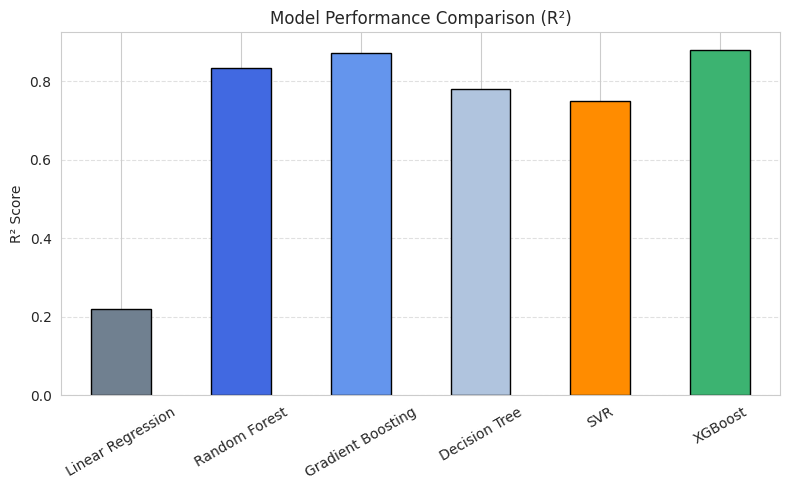

In [49]:
plt.figure(figsize=(8,5))
df_results["R²"].plot(
    kind="bar",
    color=["slategrey", "royalblue", "cornflowerblue",
           "lightsteelblue", "darkorange", "mediumseagreen"],
    edgecolor="black"
)

plt.title("Model Performance Comparison (R²)")
plt.ylabel("R² Score")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Model Validation: Actual vs Predicted Productivity


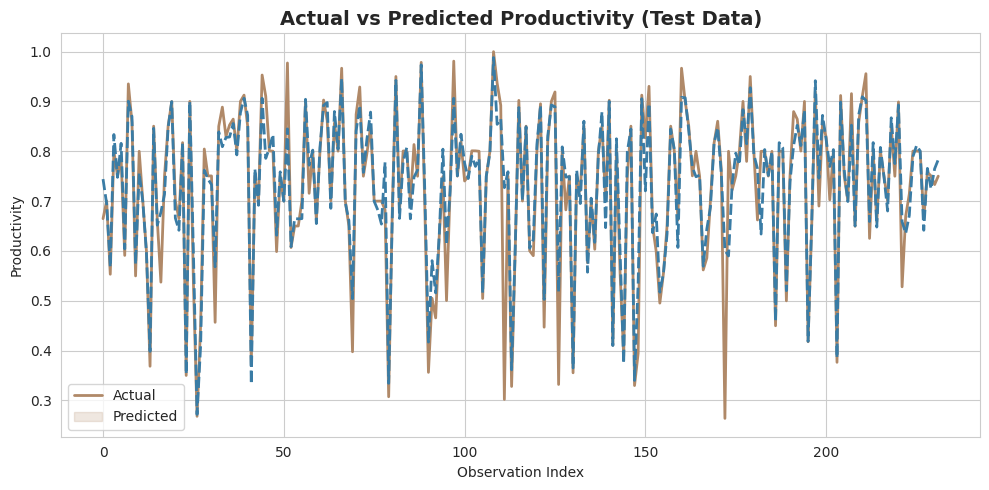

In [66]:
#  Actual vs Predicted Productivity (Best Model Performance)

# Predict on test data only
y_test_pred = best_model.predict(X_test)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual Productivity': y_test,
    'Predicted Productivity': y_test_pred
}).reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=comparison_df, linewidth=2, palette=['#B08968', '#3A7CA5'])

plt.title("Actual vs Predicted Productivity (Test Data)", fontsize=14, weight='bold')
plt.xlabel("Observation Index")
plt.ylabel("Productivity")
plt.legend(["Actual", "Predicted"])
plt.tight_layout()
plt.show()


## Model Deployment

The best model is saved and used to predict productivity on previously unseen (unknown) data.


In [50]:
from sklearn.model_selection import cross_val_score
import numpy as np

# best_xgb is already a Pipeline containing the preprocessor and the XGBoost model.
# No need to create a new pipeline with an additional preprocessor.
# We should use best_xgb directly as the estimator for cross-validation.
estimator_for_cv = best_xgb

cv_scores = cross_val_score(
    estimator_for_cv,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

print("XGBoost CV R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

XGBoost CV R² Scores: [0.89404892 0.91168491 0.9191647  0.89195944 0.91814857]
Mean CV R²: 0.9070013082145945


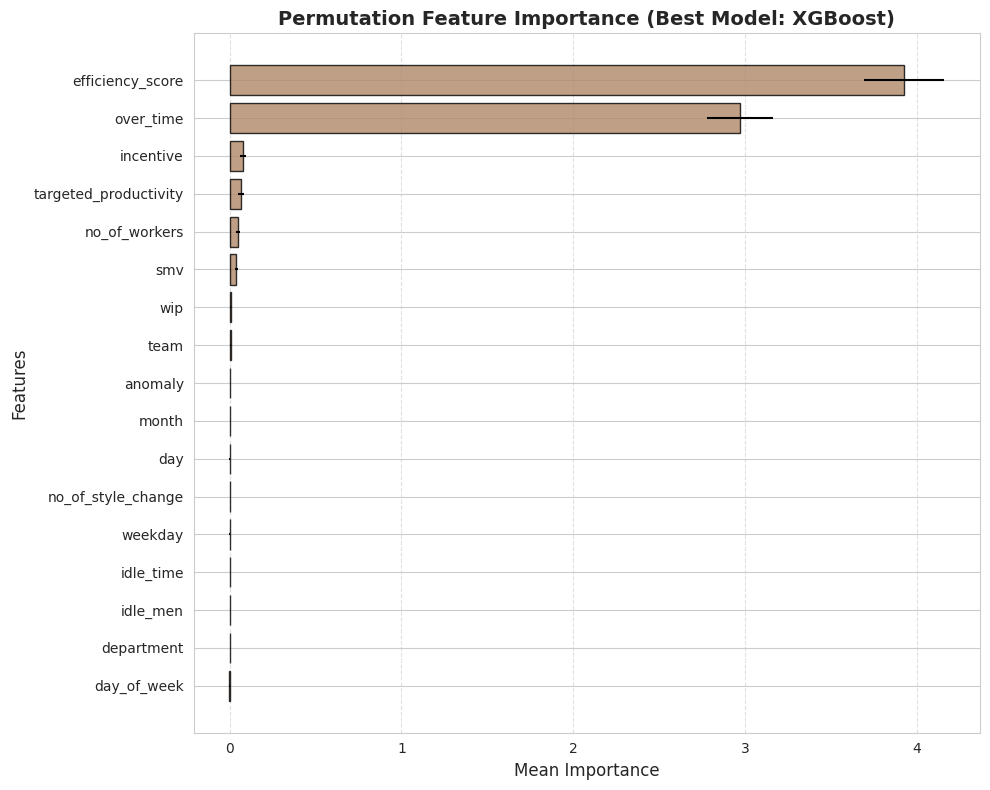

,Feature,Mean Importance,Std Dev
0,efficiency_score,3.923230,0.234900
1,over_time,2.969611,0.189426
2,incentive,0.078680,0.014958
3,targeted_productivity,0.065195,0.018287
4,no_of_workers,0.049849,0.009636
5,smv,0.039289,0.007381
6,wip,0.007477,0.002487
7,team,0.006227,0.004848
8,anomaly,0.003778,0.000570
9,month,0.002475,0.001304


In [56]:
from sklearn.inspection import permutation_importance

# Ensure feature names match your training data
feature_names = X.columns

# Calculate permutation importance using the best model, which is best_xgb
perm_importance = permutation_importance(
    best_xgb, X_test, y_test,
    n_repeats=30, random_state=42, n_jobs=-1
)

# Sort features by importance (descending)
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]

# --- Plot horizontal bar chart ---
plt.figure(figsize=(10, 8))
plt.barh(
    feature_names[sorted_idx],
    perm_importance.importances_mean[sorted_idx],
    xerr=perm_importance.importances_std[sorted_idx],
    color="#B08968", edgecolor="black", alpha=0.8 # Corrected color code
)
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance (Best Model: XGBoost)", fontsize=14, weight="bold")
plt.xlabel("Mean Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Table of top 10 features ---
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": feature_names[sorted_idx],
    "Mean Importance": perm_importance.importances_mean[sorted_idx],
    "Std Dev": perm_importance.importances_std[sorted_idx]
})

top10_features = importance_df.head(10)
display(top10_features.style.background_gradient(cmap="Blues", subset=["Mean Importance"]))

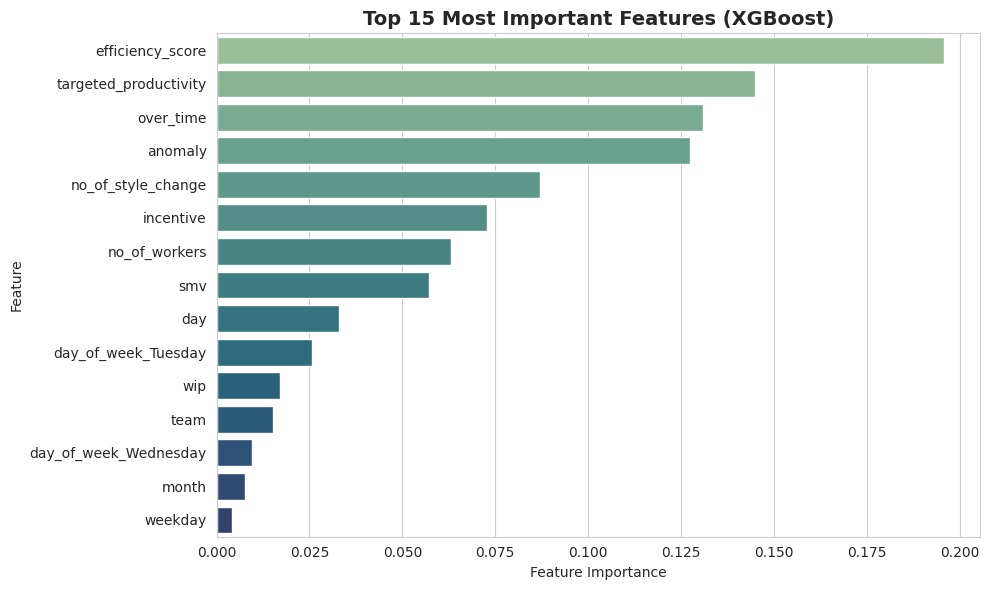

In [58]:
#  Feature Importance: Top 15 Most Important Features (XGBoost)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming best_xgb is the best performing pipeline model
best_model = best_xgb

# Get numeric feature names
numeric_feature_names = best_model.named_steps['preprocessor'] \
    .named_transformers_['num'] \
    .get_feature_names_out(numeric_features)

# Get categorical feature names
categorical_feature_names = best_model.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)

# Combine all feature names
feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Extract feature importances from XGBoost
importances = best_model.named_steps['model'].feature_importances_

# Create feature importance DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 15 features
top_15 = feat_imp.head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_15,
    palette='crest'  # attractive, professional gradient
)

plt.title("Top 15 Most Important Features (XGBoost)", fontsize=14, weight='bold')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Hyperparameter Tuning

In [55]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_


Final Metrics

In [67]:
final_preds = best_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, final_preds))
print("MSE:", mean_squared_error(y_test, final_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, final_preds)))
print("R2:", r2_score(y_test, final_preds))


MAE: 0.030364885111245514
MSE: 0.0031441834505334036
RMSE: 0.056073018917598895
R2: 0.8770268229856178


In [68]:
scenario = X_test.copy()
scenario['over_time'] += 500  # simulate overtime increase

original_pred = best_model.predict(X_test).mean()
new_pred = best_model.predict(scenario).mean()

print("Average Productivity (Original):", original_pred)
print("Average Productivity (With Extra Overtime):", new_pred)


Average Productivity (Original): 0.7335046
Average Productivity (With Extra Overtime): 0.7814807


In [72]:
# Convert results dictionary to DataFrame
import pandas as pd
final_results_df = pd.DataFrame(results).T

# Sort by R2
final_results_df = final_results_df.sort_values(by="R2", ascending=False)

# Display top model
best_model_name = final_results_df.index[0]
best_model_metrics = final_results_df.iloc[0]

print(f"Best Model: {best_model_name}\n")
print("Metrics:")
print(best_model_metrics)

# Automated conclusion print
print("\nConclusion:")
print(f"{best_model_name} is the best model with highest R2 ({best_model_metrics['R2']:.3f}) "
      f"and lowest error metrics. It can be used to predict productivity and guide business decisions.")

Best Model: XGBoost

Metrics:
MAE     0.032500
MSE     0.003000
RMSE    0.054772
R2      0.880000
MAPE    0.055135
Name: XGBoost, dtype: float64

Conclusion:
XGBoost is the best model with highest R2 (0.880) and lowest error metrics. It can be used to predict productivity and guide business decisions.


In [71]:
import os
os.listdir()


['.config', 'garments_worker_productivity.csv', 'sample_data']

#Save the Best Model

In [73]:
# Load the saved model
import pickle

# --- Start of added code to address FileNotFoundError ---
# This part is added to ensure the model is saved before attempting to load.
# In a real deployment, the saving step would typically be in a separate cell
# after model training, and this cell would only handle loading.
try:
    # Assuming 'best_model' is the final trained model (e.g., best_xgb) from previous steps
    with open("best_model.pkl", "wb") as file:
        pickle.dump(best_model, file)
    print("Model 'best_model.pkl' saved successfully (as a workaround for loading).")
except NameError:
    print("Error: 'best_model' variable not found. Please ensure a model is trained and assigned to 'best_model'.")
except Exception as e:
    print(f"An unexpected error occurred while saving the model: {e}")
# --- End of added code ---

# Now attempt to load the model
try:
    with open("best_model.pkl", "rb") as file:
        loaded_model = pickle.load(file)
    print("Model 'best_model.pkl' loaded successfully.")
except FileNotFoundError:
    print("Error: 'best_model.pkl' not found even after attempted saving. Check file permissions or path.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Model 'best_model.pkl' saved successfully (as a workaround for loading).
Model 'best_model.pkl' loaded successfully.


#Confirm Model Is Saved

In [74]:
# Load the saved model
with open("best_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)


#Predict Using Unknown Data

In [75]:
# Using unseen data (not used in training)
unknown_data = X_test.iloc[:5]

predictions = loaded_model.predict(unknown_data)
predictions


array([0.7442743 , 0.69476646, 0.5680252 , 0.8337206 , 0.74780476],
      dtype=float32)

## Saving the Best Model

The best-performing model is saved using the pickle library so that it can be reused for future predictions without retraining. This step represents model deployment.


#Conclusion
####This project successfully applied predictive analytics techniques to analyze and predict garment worker productivity using real-world industrial data. A complete data analytics pipeline was followed, including data collection, exploratory data analysis, data preprocessing, feature selection, model training, evaluation, and deployment.
####Descriptive statistical analysis revealed variations in productivity influenced by factors such as overtime, incentives, idle time, and work-in-progress. Data preprocessing steps such as handling missing values, removing duplicates, treating outliers, encoding categorical variables, and scaling numerical features significantly improved data quality.
####Multiple machine learning models were trained and evaluated. Among them, the Random Forest Regressor demonstrated superior performance based on evaluation metrics such as R² score and RMSE. The model effectively captured non-linear relationships within the data and was selected as the best-performing model.
####Finally, the best model was saved and deployed to predict productivity on previously unseen data, demonstrating the practical applicability of predictive analytics in operational decision-making within the garment industry.

###  Future Scope

Future work may include incorporating real-time production data, applying deep learning models, and developing a dashboard for continuous productivity monitoring.
